In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xagg as xa
import geopandas as gp
import rioxarray
import dask
from os.path import isfile
from dask.distributed import Queue

import pyproj
pyproj.datadir.set_data_dir('/storage/home/d/dcl5300/work/ENVS/cropswitching/share/proj')

import warnings
warnings.simplefilter("ignore", RuntimeWarning) # Ignore invalid arcsin() in EDD calculation

dask.config.set({'array.slicing.split_large_chunks': False})

## Dask (cluster)

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1, resource_spec='pmem=20GB', memory='20GB', walltime='00:60:00')

In [3]:
# print(cluster.job_script())

In [4]:
cluster.scale(jobs=25)  # ask for jobs

In [5]:
from dask.distributed import Client
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.202:45748,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Function definitions

In [7]:
# Get unique fips codes
def get_unique_fips():
    yield_path = '../data/historical/yields/'

    ufips = np.array([])
    for crop in ['maize', 'cotton', 'soy', 'rice', 'sorghum', 'barley', 'spring_wheat', 'winter_wheat']:
        tmp = pd.read_csv(yield_path + crop + '_all.csv')
        tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
        ufips = np.append(ufips, tmp['fips'].unique())
    
    ufips = np.unique(ufips)
    
    return ufips

In [8]:
# Degree day function
def above_threshold_each(mins, maxs, threshold):
    """Use a sinusoidal approximation to estimate the number of Growing
    Degree-Days above a given threshold, using daily minimum and maximum
    temperatures.
    mins and maxs are numpy arrays; threshold is in the same units."""

    """
    Code from James Rising (https://github.com/jrising/research-common/blob/master/python/gdd.py)
    """

    # Determine crossing points, as a fraction of the day
    plus_over_2 = (mins + maxs)/2
    minus_over_2 = (maxs - mins)/2
    two_pi = 2*np.pi
    # d0s is the times of crossing above; d1s is when cross below
    d0s = np.arcsin((threshold - plus_over_2) / minus_over_2) / two_pi
    d1s = .5 - d0s

    # If always above or below threshold, set crossings accordingly
    aboves = mins >= threshold
    belows = maxs <= threshold

    d0s[aboves] = 0
    d1s[aboves] = 1
    d0s[belows] = 0
    d1s[belows] = 0

    # Calculate integral
    F1s = -minus_over_2 * np.cos(2*np.pi*d1s) / two_pi + plus_over_2 * d1s
    F0s = -minus_over_2 * np.cos(2*np.pi*d0s) / two_pi + plus_over_2 * d0s
    return F1s - F0s - threshold * (d1s - d0s)

# ufunc for dask
def edd_ufunc_annual(tasmin, tasmax, threshold):
    return xr.apply_ufunc(above_threshold_each,
                          tasmin, tasmax, threshold,
                          dask = 'allowed')

In [9]:
# Get soil moisture quantiles over entire historical time period (1950-2013)
def get_SM_quantiles(dsSM, model, quantiles, season):
    for q in quantiles:
        tmp = dsSM.chunk(dict(time=-1, lat=20, lon=20)).quantile(q=float(q)/100., dim='time')['soilMoist1'].compute()
        tmp.to_netcdf('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/' + model + 
                      '/quantiles/' + model + '_VIC_sm_q' + q + '_' + season + '.nc')

In [10]:
# Calculate predictors: EDD conditioned on SM quantile
def get_predictors_EDD_SM_Q(dsT, dsSM, model, T_thresh, crop, season):
    # DataArray
    dsSM = dsSM['soilMoist1']
    
    # Read soil moisture quantiles
    path = '/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/' + model + '/quantiles/' + model
    sm10 = xr.open_dataset(path + '_VIC_sm_q10'  '_' + season + '.nc')['soilMoist1']
    sm30 = xr.open_dataset(path + '_VIC_sm_q30'  '_' + season + '.nc')['soilMoist1']
    sm70 = xr.open_dataset(path + '_VIC_sm_q70'  '_' + season + '.nc')['soilMoist1']
    sm90 = xr.open_dataset(path + '_VIC_sm_q90'  '_' + season + '.nc')['soilMoist1']
    
    # Calculate daily EDD
    EDD = edd_ufunc_annual(dsT['Tmin'], dsT['Tmax'], threshold = T_thresh[1])
    
    # Calculate daily GDD
    GDD = edd_ufunc_annual(dsT['Tmin'], dsT['Tmax'], threshold = T_thresh[0])
    GDD = GDD - EDD
    
    # Combine
    DD_SM = xr.combine_by_coords([EDD.to_dataset(name='EDD'),
                              GDD.to_dataset(name='GDD'),
                              dsT['Prec'].to_dataset(name = 'prcp')])
    
    # Annual degree days without SM
    DD_SM = DD_SM.resample(time='Y').sum().compute()
    
    # EDD/SM variables
    DD_SM['EDD_SM_q0_10'] = EDD.where(dsSM <= sm10).resample(time='Y').sum().compute()
    DD_SM['EDD_SM_q10_30'] = EDD.where((dsSM > sm10) & (dsSM <= sm30)).resample(time='Y').sum().compute()
    DD_SM['EDD_SM_q30_70'] = EDD.where((dsSM > sm30) & (dsSM < sm70)).resample(time='Y').sum().compute()
    DD_SM['EDD_SM_q70_90'] = EDD.where((dsSM >= sm70) & (dsSM < sm90)).resample(time='Y').sum().compute()
    DD_SM['EDD_SM_q90_100'] = EDD.where(dsSM >= sm90).resample(time='Y').sum().compute()
    
    # Standard SM metrics
    DD_SM['SM_mean'] = dsSM.resample(time='Y').mean().compute()
    # SM weekly max/min
    DD_SM['SM_week_max'] = dsSM.resample(time='W').mean().resample(time='Y').max().compute()
    DD_SM['SM_week_min'] = dsSM.resample(time='W').mean().resample(time='Y').min().compute()
    
    # Get squares
    DD_SM['SM_mean2'] = DD_SM['SM_mean']**2
    DD_SM['prcp2'] = DD_SM['prcp']**2
    
    # Tidy
    DD_SM = DD_SM.drop('quantile')
    DD_SM.attrs['NOTE1'] = 'Degree Days calculated as in DOI: 10.1111/agec.12315 supplementary material with threshold 29C. Author: David Lafferty - University of Illinois (davidcl2@illinois.edu). Date: Aug 2021'
    DD_SM.attrs['NOTE2'] = 'For original netcdf files see: http://loca.ucsd.edu/'
    DD_SM['SM_mean'].attrs['units'] = 'mm'
    DD_SM['SM_week_max'].attrs['units'] = 'mm'
    DD_SM['SM_week_min'].attrs['units'] = 'mm'
    DD_SM['prcp'].attrs['units'] = 'mm'
    
    # Save 
    DD_SM.to_netcdf('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/' + model + 
                    '/out/' + model + '_VIC_' + crop + '_quantile_predictors.nc')

In [11]:
# Calculate predictors: EDD conditioned on SM difference from mean (Haqiqi 21)
def get_predictors_EDD_SM_H21(dsT, dsSM, model, T_thresh, crop):
    # DataArray
    dsSM = dsSM['soilMoist1']
    
    # Soil moisture difference
    sm_mean = dsSM.chunk(dict(time=-1, lat=20, lon=20)).mean(dim='time').compute()
    sm_diff = (dsSM - sm_mean)
    
    # Calculate daily EDD
    EDD = edd_ufunc_annual(dsT['Tmin'], dsT['Tmax'], threshold = T_thresh[1])
    
    # Calculate daily GDD
    GDD = edd_ufunc_annual(dsT['Tmin'], dsT['Tmax'], threshold = T_thresh[0])
    GDD = GDD - EDD
    
    # Combine
    DD_SM = xr.combine_by_coords([EDD.to_dataset(name='EDD'),
                              GDD.to_dataset(name='GDD'),
                              dsT['Prec'].to_dataset(name = 'prcp')])
    
    # Annual degree days without SM
    DD_SM = DD_SM.resample(time='Y').sum().compute()
    
    # EDD/SM variables
    DD_SM['EDD_SM_75_below'] = EDD.where(sm_diff < -7.5).resample(time='Y').sum().compute()
    DD_SM['EDD_SM_25_75_below'] = EDD.where((sm_diff > -7.5) & (sm_diff <= -2.5)).resample(time='Y').sum().compute()
    DD_SM['EDD_SM_0_25_norm'] = EDD.where((sm_diff > -2.5) & (sm_diff < 2.5)).resample(time='Y').sum().compute()
    DD_SM['EDD_SM_25_75_above'] = EDD.where((sm_diff >= 2.5) & (sm_diff < 7.5)).resample(time='Y').sum().compute()
    DD_SM['EDD_SM_75_above'] = EDD.where(sm_diff >= 7.5).resample(time='Y').sum().compute()
    
    # Standard SM metrics
    DD_SM['SM_mean'] = dsSM.resample(time='Y').mean().compute()
    # SM weekly max/min
    DD_SM['SM_week_max'] = dsSM.resample(time='W').mean().resample(time='Y').max().compute()
    DD_SM['SM_week_min'] = dsSM.resample(time='W').mean().resample(time='Y').min().compute()
    
    # Get squares
    DD_SM['SM_mean2'] = DD_SM['SM_mean']**2
    DD_SM['prcp2'] = DD_SM['prcp']**2
    
    # Tidy
    DD_SM.attrs['NOTE1'] = 'Degree Days calculated as in DOI: 10.1111/agec.12315 supplementary material with threshold 29C. Author: David Lafferty - University of Illinois (davidcl2@illinois.edu). Date: Aug 2021'
    DD_SM.attrs['NOTE2'] = 'For original netcdf files see: http://loca.ucsd.edu/'
    DD_SM['SM_mean'].attrs['units'] = 'mm'
    DD_SM['SM_week_max'].attrs['units'] = 'mm'
    DD_SM['SM_week_min'].attrs['units'] = 'mm'
    DD_SM['prcp'].attrs['units'] = 'mm'
    
    # Save 
    DD_SM.to_netcdf('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/' + model + 
                    '/out/' + model + '_VIC_' + crop + '_H21_predictors.nc')

In [12]:
# Calculate predictors: EDD and SM monthly values
def get_predictors_EDD_SM_intra(dsT, dsSM, model, T_thresh, crop):
    # DataArray
    dsSM = dsSM['soilMoist1']
    
    # Calculate daily EDD
    EDD = edd_ufunc_annual(dsT['Tmin'], dsT['Tmax'], threshold = T_thresh[1])
    
    # Calculate daily GDD
    GDD = edd_ufunc_annual(dsT['Tmin'], dsT['Tmax'], threshold = T_thresh[0])
    GDD = GDD - EDD
    
    # Combine
    DD_SM = xr.combine_by_coords([EDD.to_dataset(name='EDD'),
                              GDD.to_dataset(name='GDD'),
                              dsT['Prec'].to_dataset(name = 'prcp')])
    
    # Monthly degree days
    DD_SM = DD_SM.resample(time='M').sum().compute()
    
    # Monthly SM
    DD_SM['SM_mean'] = dsSM.resample(time='M').mean().compute()
    
    # Weekly SM
    DD_SM['SM_week_max'] = dsSM.resample(time='W').mean().resample(time='M').max().compute()
    DD_SM['SM_week_min'] = dsSM.resample(time='W').mean().resample(time='M').min().compute()
    
    # Get squares
    DD_SM['SM_mean2'] = DD_SM['SM_mean']**2
    DD_SM['prcp2'] = DD_SM['prcp']**2
    
    # Tidy
    DD_SM.attrs['NOTE1'] = 'Degree Days calculated as in DOI: 10.1111/agec.12315 supplementary material with threshold 29C. Author: David Lafferty - University of Illinois (davidcl2@illinois.edu). Date: Aug 2021'
    DD_SM.attrs['NOTE2'] = 'For original netcdf files see: http://loca.ucsd.edu/'
    DD_SM['SM_mean'].attrs['units'] = 'mm'
    DD_SM['SM_week_max'].attrs['units'] = 'mm'
    DD_SM['SM_week_min'].attrs['units'] = 'mm'
    DD_SM['prcp'].attrs['units'] = 'mm'
    
    # Save 
    DD_SM.to_netcdf('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/' + model + 
                    '/out/' + model + '_VIC_' + crop + '_intra_predictors.nc')

In [13]:
# Aggregation function for dask delayed
def func_agg(fips, model, predictors, crop):
    weights_path = '/gpfs/group/kaf26/default/dcl5300/cropland_data_layer/county_weights/'
    
    try:
        # Shapefile and county bounds
        gdf = gp.read_file('/storage/work/dcl5300/bcsd_maize_scripts/tools/plotting_tools/counties_contig_plot.shp')
        gdf = gdf.to_crs('WGS 84')
        gdf_fips = gdf.query('fips == "' + fips + '"')
        xmin, ymin, xmax, ymax = gdf_fips.geometry.total_bounds
        
        # Predictor vars
        path = '/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/'
        ds = xr.open_dataset(path + model + '/out/' + model + '_VIC_' + crop + '_' + predictors + '.nc')
        ds = ds.where((ds.lat >= ymin) & (ds.lat <= ymax) & (ds.lon >= xmin) & (ds.lon <= xmax), drop=True)
        
        # Read in weights
        ds_weights = xr.open_dataset(weights_path + fips + '_08-20.nc')
        ds_weights = ds_weights.coarsen(x=10, y=10, boundary='pad').mean()

        # Aggregate
        weightmap = xa.pixel_overlaps(ds, gdf_fips, weights = ds_weights.cropland_avg)
        aggregated = xa.aggregate(ds, weightmap).to_dataset().to_dataframe().reset_index().drop(columns = ['pix_idx'])
        
        # For a few counties the weighting results in all values being zero
        if len(aggregated.query('GDD == 0.0')) > 0.0:
            weightmap = xa.pixel_overlaps(ds, gdf_fips)
            aggregated = xa.aggregate(ds, weightmap).to_dataset().to_dataframe().reset_index().drop(columns = ['pix_idx'])    
        
        # Otherwise workers will store for each county 
        del ds
        del ds_weights
        del gdf
        del gdf_fips
        del weightmap
        
        return aggregated
    
    except Exception as e:
        print("{} / {} Failed : {}".format(model, fips, str(e)))

In [14]:
# Subset US
def subset_us(df):
    return df.where((df.latitude < 50.) & 
                    (df.latitude > 24.) & 
                    (df.longitude < -65.) & 
                    (df.longitude > -124.), drop=True)

# Irrigation function
def calculate_irr_fraction(rfd, irr):
    ## Returns fraction of area that is irrigated
    
    # Get locations with 0./0.
    nans = np.logical_and(rfd['cropland_area'].max(dim='z') == 0., irr['cropland_area'].max(dim='z') == 0.)
    
    # Calculate all locations
    frac = irr['cropland_area'].max(dim='z') / (rfd['cropland_area'].max(dim='z') + irr['cropland_area'].max(dim='z'))
    
    frac = xr.where(nans, np.nan, frac) # Replace nans
    frac = frac.where(frac <= 1., np.nan) # Replace fill value with nan
    
    return frac

## Maize

In [13]:
# Livneh soil moisture obs
dsSM = xr.open_mfdataset('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/Livneh/raw/soilMoist*', chunks='auto', parallel=True)

# Livneh temperature obs
dsT = xr.open_mfdataset('/gpfs/group/kzk10/default/public/LOCA/training/livneh_NAmerExt_15Oct2014*', chunks='auto', parallel=True)

In [14]:
# Need same grid and coords
dsSM = dsSM.rename({'Time':'time', 'Lat':'lat', 'Lon':'lon'})
dsT = dsT.where(dsT.lat >= dsSM.lat.min(), drop=True)

# Corn growing season (following Ortiz-Bobea ERL)
dsSM = dsSM.sel(time=dsSM.time.dt.month.isin([4, 5, 6, 7, 8, 9]))
dsT = dsT.sel(time=dsT.time.dt.month.isin([4, 5, 6, 7, 8, 9]))

In [31]:
# %%time
# # Get soil moisture quantiles over entire historical time period (1950-2013)
# # get_SM_quantiles(dsSM, 'Livneh', ['10', '30', '70', '90'], '4-9')

# # Calculate predictors (EDD conditioned on quantiles)
# get_predictors_EDD_SM_Q(dsT, dsSM, 'Livneh', [10.0, 29.0], 'maize', '4-9') # bounds from Schenker-Roberts 2009 (I checked lower bound on Powerpoint)

In [15]:
%%time
# Calculate predictors (following Haqiqi et al 2021)
get_predictors_EDD_SM_H21(dsT, dsSM, 'Livneh', [10.0, 29.0], 'maize')

CPU times: user 5min 7s, sys: 11.6 s, total: 5min 18s
Wall time: 13min


In [18]:
%%time
# Calculate predictors (intra-seasonal monthly)
get_predictors_EDD_SM_intra(dsT, dsSM, 'Livneh', [10.0, 29.0], 'maize')

CPU times: user 2min 55s, sys: 18.3 s, total: 3min 14s
Wall time: 5min 17s


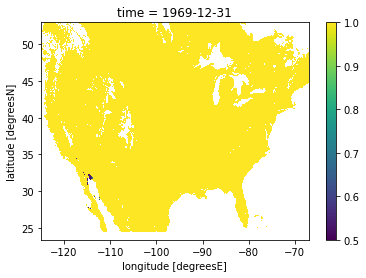

In [36]:
# Check
it = 19
DD_SM = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/Livneh/out/Livneh_VIC_maize_quantile_predictors.nc')
check = DD_SM.isel(time=it)['EDD_SM_q0_10'] + DD_SM.isel(time=it)['EDD_SM_q10_30'] + DD_SM.isel(time=it)['EDD_SM_q30_70'] + DD_SM.isel(time=it)['EDD_SM_q70_90'] + DD_SM.isel(time=it)['EDD_SM_q90_100']
(DD_SM.isel(time=it)['EDD'] / check).plot()

### Aggregate to county level

In [21]:
# Get unique fips codes
ufips = get_unique_fips()

In [22]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'quantile_predictors', 'maize')
    delayed_res.append(tmp_agg)
    
# Run
res = dask.compute(*delayed_res)

# To dataframe
df_res = pd.concat(res)
df_res['year'] = df_res['time'].dt.year
df_res.drop(columns = 'time', inplace=True)

df_res.to_csv('../data/historical/predictors/Livneh/Livneh_maize_quantile_predictors.csv', index=False)

CPU times: user 1min 38s, sys: 3.57 s, total: 1min 41s
Wall time: 10min 46s


In [32]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'H21_predictors', 'maize')
    delayed_res.append(tmp_agg)
    
# Run
res = dask.compute(*delayed_res)

# To dataframe
df_res = pd.concat(res)
df_res['year'] = df_res['time'].dt.year
df_res.drop(columns = 'time', inplace=True)

df_res.to_csv('../data/historical/predictors/Livneh/Livneh_maize_H21_predictors.csv', index=False)

CPU times: user 1min 14s, sys: 2.59 s, total: 1min 16s
Wall time: 6min 39s


In [37]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'intra_predictors', 'maize')
    delayed_res.append(tmp_agg)
    
# Run
res = dask.compute(*delayed_res)

CPU times: user 2min 25s, sys: 5.36 s, total: 2min 30s
Wall time: 15min 23s


In [49]:
# Monthly predictors need some organization:
# To dataframe
df_res = pd.concat(res)
df_res['year'] = df_res['time'].dt.year
df_res['month'] = df_res['time'].dt.month
df_res.drop(columns = 'time', inplace=True)

# Subset growing season
months = [4,5,6,7,8,9]
df_res_season = df_res[df_res.month.isin(months)]

# Predictors
predictor_vars = df_res_season.columns[1:-2]

# Final product
df_final = df_res_season[['fips' ,'year']].copy()

# Loop through each month, predictor
for month in months:
    # Temporary df with single month
    temp = df_res_season.query('month == ' + str(month)).copy()
    
    # Rename each predictor to include monthly suffix
    for var in predictor_vars:
        temp.rename(columns = {var : var + '_' + str(month)}, inplace=True)
        
    # Merge
    df_final = pd.merge(df_final, temp.drop(columns = 'month'), how='inner', on = ['fips', 'year'])
    
# There are many duplicate rows, not sure why
df_final.drop_duplicates(inplace=True)
# Save
df_final.to_csv('../data/historical/predictors/Livneh/Livneh_maize_intra_predictors.csv', index=False)

## Soy

In [15]:
# Livneh soil moisture obs
dsSM = xr.open_mfdataset('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/Livneh/raw/soilMoist*', chunks='auto', parallel=True)

# Livneh temperature obs
dsT = xr.open_mfdataset('/gpfs/group/kzk10/default/public/LOCA/training/livneh_NAmerExt_15Oct2014*', chunks='auto', parallel=True)

In [16]:
# Need same grid and coords
dsSM = dsSM.rename({'Time':'time', 'Lat':'lat', 'Lon':'lon'})
dsT = dsT.where(dsT.lat >= dsSM.lat.min(), drop=True)

# Soy growing season (following Ortiz-Bobea ERL)
dsSM = dsSM.sel(time=dsSM.time.dt.month.isin([4, 5, 6, 7, 8, 9]))
dsT = dsT.sel(time=dsT.time.dt.month.isin([4, 5, 6, 7, 8, 9]))

In [17]:
%%time
# # Calculate predictors (EDD conditioned on quantiles)
# get_predictors_EDD_SM_Q(dsT, dsSM, 'Livneh', [10.0, 30.0], 'soy', '4-9') # bounds from Schlenker & Roberts 2009 (I checked lower bound on Powerpoint)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [18]:
%%time
# Calculate predictors following Haqiqi et al 2021: EDD conditioned on differences from mean
get_predictors_EDD_SM_H21(dsT, dsSM, 'Livneh', [10.0, 30.0], 'soy')

CPU times: user 7min 22s, sys: 18.5 s, total: 7min 40s
Wall time: 25min 47s


In [19]:
%%time
# Calculate predictors: monthly
get_predictors_EDD_SM_intra(dsT, dsSM, 'Livneh', [10.0, 30.0], 'soy')

CPU times: user 2min 47s, sys: 19.3 s, total: 3min 6s
Wall time: 5min 7s


### Aggregate to county level

In [20]:
# Get unique fips codes
ufips = get_unique_fips()

In [21]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'H21_predictors', 'soy')
    delayed_res.append(tmp_agg)
    
# Run
res = dask.compute(*delayed_res)

# To dataframe
df_res = pd.concat(res)
df_res['year'] = df_res['time'].dt.year
df_res.drop(columns = 'time', inplace=True)

df_res.to_csv('../data/historical/predictors/Livneh/Livneh_soy_H21_predictors.csv', index=False)

CPU times: user 1min 12s, sys: 2.46 s, total: 1min 14s
Wall time: 6min 26s


In [1]:
# %%time
# # Parallelize
# delayed_res = []
# for fips in ufips:
#     tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'quantile_predictors', 'soy')
#     delayed_res.append(tmp_agg)
    
# # Run
# res = dask.compute(*delayed_res)

# # To dataframe
# df_res = pd.concat(res)
# df_res['year'] = df_res['time'].dt.year
# df_res.drop(columns = 'time', inplace=True)

# df_res.to_csv('../data/historical/predictors/Livneh/Livneh_soy_quantile_predictors.csv', index=False)

In [22]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'intra_predictors' ,'soy')
    delayed_res.append(tmp_agg)
    
# Run
res = dask.compute(*delayed_res)

# Monthly predictors need some organization:

# To dataframe
df_res = pd.concat(res)
df_res['year'] = df_res['time'].dt.year
df_res['month'] = df_res['time'].dt.month
df_res.drop(columns = 'time', inplace=True)

# Subset growing season
months = [4,5,6,7,8,9]
df_res_season = df_res[df_res.month.isin(months)]

# Predictors
predictor_vars = df_res_season.columns[1:-2]

# Final product
df_final = df_res_season[['fips' ,'year']].copy()

# Loop through each month, predictor
for month in months:
    # Temporary df with single month
    temp = df_res_season.query('month == ' + str(month)).copy()
    
    # Rename each predictor to include monthly suffix
    for var in predictor_vars:
        temp.rename(columns = {var : var + '_' + str(month)}, inplace=True)
        
    # Merge
    df_final = pd.merge(df_final, temp.drop(columns = 'month'), how='inner', on = ['fips', 'year'])
    
# There are many duplicate rows, not sure why
df_final.drop_duplicates(inplace=True)
# Save
df_final.to_csv('../data/historical/predictors/Livneh/Livneh_soy_intra_predictors.csv', index=False)

CPU times: user 2min 49s, sys: 7.15 s, total: 2min 56s
Wall time: 16min 4s


## Sorghum

In [ ]:
##### Same as soy ########

# Growing season: Ortiz-Bobea ERL
# Bounds: https://iopscience.iop.org/article/10.1088/1748-9326/5/1/014010

## Cotton

In [16]:
# Livneh soil moisture obs
dsSM = xr.open_mfdataset('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/Livneh/raw/soilMoist*', chunks='auto', parallel=True)

# Livneh temperature obs
dsT = xr.open_mfdataset('/gpfs/group/kzk10/default/public/LOCA/training/livneh_NAmerExt_15Oct2014*', chunks='auto', parallel=True)

In [17]:
# Need same grid and coords
dsSM = dsSM.rename({'Time':'time', 'Lat':'lat', 'Lon':'lon'})
dsT = dsT.where(dsT.lat >= dsSM.lat.min(), drop=True)

# Soy growing season (following Ortiz-Bobea ERL)
dsSM = dsSM.sel(time=dsSM.time.dt.month.isin([4, 5, 6, 7, 8, 9]))
dsT = dsT.sel(time=dsT.time.dt.month.isin([4, 5, 6, 7, 8, 9]))

In [25]:
# %%time
# # Calculate predictors: EDD conditioned on quantiles
# get_predictors_EDD_SM_Q(dsT, dsSM, 'Livneh', [15.0, 32.0], 'cotton', '4-9') # bounds from Schlenker & Roberts 2009 (I checked lower bound on Powerpoint)

In [18]:
%%time
# Calculate predictors following Haqiqi et al 2021: EDD conditioned on differences from mean
get_predictors_EDD_SM_H21(dsT, dsSM, 'Livneh', [15.0, 32.0], 'cotton')

CPU times: user 5min 2s, sys: 13.9 s, total: 5min 16s
Wall time: 12min 25s


In [26]:
%%time
# Calculate predictors: monthly
get_predictors_EDD_SM_intra(dsT, dsSM, 'Livneh', [15.0, 32.0], 'cotton')

CPU times: user 2min 53s, sys: 19.1 s, total: 3min 12s
Wall time: 5min 31s


### Aggregate to county level

In [15]:
# Get unique fips codes
ufips = get_unique_fips()

In [20]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'H21_predictors', 'cotton')
    delayed_res.append(tmp_agg)
    
# Run
res = dask.compute(*delayed_res)

# To dataframe
df_res = pd.concat(res)
df_res['year'] = df_res['time'].dt.year
df_res.drop(columns = 'time', inplace=True)

df_res.to_csv('../data/historical/predictors/Livneh/Livneh_cotton_H21_predictors.csv', index=False)

CPU times: user 1min 9s, sys: 2.27 s, total: 1min 11s
Wall time: 6min 22s


In [ ]:
# %%time
# # Parallelize
# delayed_res = []
# for fips in ufips:
#     tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'quantile_predictors', 'cotton')
#     delayed_res.append(tmp_agg)
    
# # Run
# res = dask.compute(*delayed_res)

# # To dataframe
# df_res = pd.concat(res)
# df_res['year'] = df_res['time'].dt.year
# df_res.drop(columns = 'time', inplace=True)

# df_res.to_csv('../data/historical/predictors/Livneh/Livneh_cotton_quantile_predictors.csv', index=False)

In [16]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'intra_predictors' ,'cotton')
    delayed_res.append(tmp_agg)
    
# Run
res = dask.compute(*delayed_res)

# Monthly predictors need some organization:

# To dataframe
df_res = pd.concat(res)
df_res['year'] = df_res['time'].dt.year
df_res['month'] = df_res['time'].dt.month
df_res.drop(columns = 'time', inplace=True)

# Subset growing season
months = [4,5,6,7,8,9]
df_res_season = df_res[df_res.month.isin(months)]

# Predictors
predictor_vars = df_res_season.columns[1:-2]

# Final product
df_final = df_res_season[['fips' ,'year']].copy()

# Loop through each month, predictor
for month in months:
    # Temporary df with single month
    temp = df_res_season.query('month == ' + str(month)).copy()
    
    # Rename each predictor to include monthly suffix
    for var in predictor_vars:
        temp.rename(columns = {var : var + '_' + str(month)}, inplace=True)
        
    # Merge
    df_final = pd.merge(df_final, temp.drop(columns = 'month'), how='inner', on = ['fips', 'year'])
    
# There are many duplicate rows, not sure why
df_final.drop_duplicates(inplace=True)
# Save
df_final.to_csv('../data/historical/predictors/Livneh/Livneh_cotton_intra_predictors.csv', index=False)

CPU times: user 2min 58s, sys: 8.07 s, total: 3min 6s
Wall time: 21min 39s


## Barley

In [15]:
# Livneh soil moisture obs
dsSM = xr.open_mfdataset('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/Livneh/raw/soilMoist*', chunks='auto', parallel=True)

# Livneh temperature obs
dsT = xr.open_mfdataset('/gpfs/group/kzk10/default/public/LOCA/training/livneh_NAmerExt_15Oct2014*', chunks='auto', parallel=True)

In [16]:
# Need same grid and coords
dsSM = dsSM.rename({'Time':'time', 'Lat':'lat', 'Lon':'lon'})
dsT = dsT.where(dsT.lat >= dsSM.lat.min(), drop=True)

# Soy growing season (following USDA NASS crop condition charts)
dsSM = dsSM.sel(time=dsSM.time.dt.month.isin([4, 5, 6, 7, 8]))
dsT = dsT.sel(time=dsT.time.dt.month.isin([4, 5, 6, 7, 8]))

In [17]:
%%time
# Calculate predictors following Haqiqi et al 2021: EDD conditioned on differences from mean
get_predictors_EDD_SM_H21(dsT, dsSM, 'Livneh', [0., 15.0], 'barley')

CPU times: user 5min 12s, sys: 11.2 s, total: 5min 23s
Wall time: 13min


### Aggregate to county level

In [18]:
# Get unique fips codes
ufips = get_unique_fips()

In [19]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'H21_predictors', 'barley')
    delayed_res.append(tmp_agg)
    
# Run
res = dask.compute(*delayed_res)

# To dataframe
df_res = pd.concat(res)
df_res['year'] = df_res['time'].dt.year
df_res.drop(columns = 'time', inplace=True)

df_res.to_csv('../data/historical/predictors/Livneh/Livneh_barley_H21_predictors.csv', index=False)

CPU times: user 1min 31s, sys: 2.7 s, total: 1min 34s
Wall time: 7min 32s


## Spring Wheat

In [20]:
# Livneh soil moisture obs
dsSM = xr.open_mfdataset('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/Livneh/raw/soilMoist*', chunks='auto', parallel=True)

# Livneh temperature obs
dsT = xr.open_mfdataset('/gpfs/group/kzk10/default/public/LOCA/training/livneh_NAmerExt_15Oct2014*', chunks='auto', parallel=True)

In [21]:
# Need same grid and coords
dsSM = dsSM.rename({'Time':'time', 'Lat':'lat', 'Lon':'lon'})
dsT = dsT.where(dsT.lat >= dsSM.lat.min(), drop=True)

# Soy growing season (following Ortiz-Bobea ERL)
dsSM = dsSM.sel(time=dsSM.time.dt.month.isin([4, 5, 6, 7, 8]))
dsT = dsT.sel(time=dsT.time.dt.month.isin([4, 5, 6, 7, 8]))

In [22]:
%%time
# Calculate predictors following Haqiqi et al 2021: EDD conditioned on differences from mean
get_predictors_EDD_SM_H21(dsT, dsSM, 'Livneh', [5.0, 26.0], 'spring_wheat')

CPU times: user 5min 16s, sys: 10.9 s, total: 5min 27s
Wall time: 13min 16s


### Aggregate to county level

In [23]:
# Get unique fips codes
ufips = get_unique_fips()

In [24]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, 'Livneh', 'H21_predictors', 'spring_wheat')
    delayed_res.append(tmp_agg)
    
# Run
res = dask.compute(*delayed_res)

# To dataframe
df_res = pd.concat(res)
df_res['year'] = df_res['time'].dt.year
df_res.drop(columns = 'time', inplace=True)

df_res.to_csv('../data/historical/predictors/Livneh/Livneh_springwheat_H21_predictors.csv', index=False)

CPU times: user 1min 51s, sys: 3.29 s, total: 1min 55s
Wall time: 9min 33s


## Covariates

### Bio-clim

In [ ]:
# Livneh temperature & precip obs
ds = xr.open_mfdataset('/gpfs/group/kzk10/default/public/LOCA/training/livneh_NAmerExt_15Oct2014*', chunks='auto', parallel=True)

In [ ]:
# Bio1: Annual mean temperature
bio1 = (ds['Tmax'] + ds['Tmin'])/2.
bio1 = bio1.resample(time='Y').mean().mean(dim='time').compute()

In [ ]:
# Resample to monthly means
ds_monthly = ds.resample(time='M').mean().compute()

In [ ]:
# Bio2: Mean 'diurnal' range
bio2 = (ds_monthly['Tmax'] - ds_monthly['Tmin']).mean(dim='time')

In [ ]:
# Bio4: Temperature seasonality (SD)
bio4 = (ds_monthly['Tmax'] + ds_monthly['Tmin']) / 2.
bio4 = bio4.resample(time='Y').std().mean(dim='time')

In [ ]:
# Bio12: Annual (total) precipitation
bio12 = ds['Prec'].resample(time='Y').sum().mean(dim='time').compute() / 100.

In [ ]:
# Bio7: Annual temperature range
bio7 = ds_monthly['Tmax'].resample(time='Y').max() - ds_monthly['Tmin'].resample(time='Y').min()
bio7 = bio7.mean(dim='time')

In [ ]:
# Bio3: Isothermality (bio2 / bio7)
bio3 = 100 * bio2 / bio7

In [ ]:
# Bio15: Precip CV
bio15 = ds_monthly['Prec'].resample(time='Y').mean() / ds_monthly['Prec'].resample(time='Y').std()
bio15 = bio15.mean(dim='time')

In [290]:
# Save
bio_all = xr.merge([bio1.rename('bio_1'),
                       bio2.rename('bio_2'),
                       bio3.rename('bio_3'),
                       bio4.rename('bio_4'),
                       bio7.rename('bio_7'),
                       bio12.rename('bio_12'),
                       bio15.rename('bio_15')])

bio_all.attrs['NOTE'] = 'https://www.worldclim.org/data/bioclim.html'
bio_all.to_netcdf('/gpfs/group/kaf26/default/dcl5300/bioclim_all.nc')

### Irrigation fraction

In [199]:
# Maize irrigation
maize_rfd = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Maize_1_rfd_area.nc')
maize_rfd = subset_us(maize_rfd)

maize_irr = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Maize_1_irr_area.nc')
maize_irr = subset_us(maize_irr)

maize_frac = calculate_irr_fraction(maize_rfd, maize_irr)

In [203]:
# Barley irrigation
barley_rfd = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Barley_1_rfd_area.nc')
barley_rfd = subset_us(barley_rfd)

barley_irr = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Barley_1_irr_area.nc')
barley_irr = subset_us(barley_irr)

barley_frac = calculate_irr_fraction(barley_rfd, barley_irr)

In [207]:
# Cotton irrigation
cotton_rfd = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Cotton_1_rfd_area.nc')
cotton_rfd = subset_us(cotton_rfd)

cotton_irr = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Cotton_1_irr_area.nc')
cotton_irr = subset_us(cotton_irr)

cotton_frac = calculate_irr_fraction(cotton_rfd, cotton_irr)

In [213]:
# Sorghum irrigation
sorghum_rfd = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Sorghum_1_rfd_area.nc')
sorghum_rfd = subset_us(sorghum_rfd)

sorghum_irr = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Sorghum_1_irr_area.nc')
sorghum_irr = subset_us(sorghum_irr)

sorghum_frac = calculate_irr_fraction(sorghum_rfd, sorghum_irr)

In [214]:
# Soybean irrigation
soy_rfd = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Soybean_1_rfd_area.nc')
soy_rfd = subset_us(soy_rfd)

soy_irr = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Soybean_1_irr_area.nc')
soy_irr = subset_us(soy_irr)

soy_frac = calculate_irr_fraction(soy_rfd, soy_irr)

In [248]:
# Winter Wheat irrigation
winter_wheat_rfd = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Wheat_1_rfd_area.nc')
winter_wheat_rfd = subset_us(winter_wheat_rfd)

winter_wheat_irr = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Wheat_1_irr_area.nc')
winter_wheat_irr = subset_us(winter_wheat_irr)

winter_wheat_frac = calculate_irr_fraction(winter_wheat_rfd, winter_wheat_irr)

In [249]:
# Spring Wheat irrigation
spring_wheat_rfd = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Wheat_2_rfd_area.nc')
spring_wheat_rfd = subset_us(spring_wheat_rfd)

spring_wheat_irr = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Wheat_2_irr_area.nc')
spring_wheat_irr = subset_us(spring_wheat_irr)

spring_wheat_frac = calculate_irr_fraction(spring_wheat_rfd, spring_wheat_irr)

In [259]:
# Rice irrigation
rice_rfd = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Rice_1_rfd_area.nc')
rice_rfd = subset_us(rice_rfd)

rice_irr = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/10_13019_J2BH-VB41/GAEZ_crop_area_monthly_2015/GZ_Rice_1_irr_area.nc')
rice_irr = subset_us(rice_irr)

rice_frac = calculate_irr_fraction(rice_rfd, rice_irr)

In [271]:
# Save
irrig_frac = xr.merge([maize_frac.rename('maize_irr_frac'),
                       rice_frac.rename('rice_irr_frac'),
                       cotton_frac.rename('cotton_irr_frac'),
                       sorghum_frac.rename('sorghum_irr_frac'),
                       winter_wheat_frac.rename('winter_wheat_irr_frac'),
                       spring_wheat_frac.rename('spring_wheat_irr_frac'),
                       soy_frac.rename('soy_irr_frac'),
                       barley_frac.rename('barley_irr_frac')])

irrig_frac.to_netcdf('/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/historical/irrigation_frac_all.nc')

### County aggregation

In [14]:
# Get unique fips codes
ufips = get_unique_fips()

In [44]:
# Updated aggregation function for dask delayed
def func_agg(fips, path, latlon):
    weights_path = '/gpfs/group/kaf26/default/dcl5300/cropland_data_layer/county_weights/'
    
    try:
        # Shapefile and county bounds
        gdf = gp.read_file('/storage/work/dcl5300/bcsd_maize_scripts/tools/plotting_tools/counties_contig_plot.shp')
        gdf = gdf.to_crs('WGS 84')
        gdf_fips = gdf.query('fips == "' + fips + '"')
        xmin, ymin, xmax, ymax = gdf_fips.geometry.total_bounds
        
        # Covariates
        ds = xr.open_dataset(path)
        if latlon:
            ds = ds.where((ds.lat >= ymin) & (ds.lat <= ymax) & (ds.lon >= xmin) & (ds.lon <= xmax), drop=True)
        else: 
            ds = ds.where((ds.latitude >= ymin) & (ds.latitude <= ymax) & (ds.longitude >= xmin) & (ds.longitude <= xmax), drop=True)
            
        # Read in weights
        ds_weights = xr.open_dataset(weights_path + fips + '_08-20.nc')
        ds_weights = ds_weights.coarsen(x=10, y=10, boundary='pad').mean()

        # Aggregate
        weightmap = xa.pixel_overlaps(ds, gdf_fips, weights = ds_weights.cropland_avg)
        aggregated = xa.aggregate(ds, weightmap).to_dataset().to_dataframe().reset_index().drop(columns = ['pix_idx'])
        
        # For a few counties the weighting results in all values being zero
        if aggregated.iloc[:, 1:].sum(axis=1)[0] == 0.0:
            weightmap = xa.pixel_overlaps(ds, gdf_fips)
            aggregated = xa.aggregate(ds, weightmap).to_dataset().to_dataframe().reset_index().drop(columns = ['pix_idx'])
        
        # Otherwise workers will store for each county 
        del ds
        del ds_weights
        del gdf
        del gdf_fips
        del weightmap
        
        return aggregated
    
    except Exception as e:
        print("{} Failed : {}".format(fips, str(e)))

In [53]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, '/gpfs/group/kaf26/default/dcl5300/GAEZ+_2015_monthly/historical/irrigation_frac_all.nc', latlon=False)
    delayed_res.append(tmp_agg)
    
# Run
res_irr = dask.compute(*delayed_res)

CPU times: user 1min 15s, sys: 2.54 s, total: 1min 18s
Wall time: 6min 33s


In [17]:
%%time
# Parallelize
delayed_res = []
for fips in ufips:
    tmp_agg = dask.delayed(func_agg)(fips, '/gpfs/group/kaf26/default/dcl5300/bioclim_all.nc', latlon=True)
    delayed_res.append(tmp_agg)
    
# Run
res_bio = dask.compute(*delayed_res)

CPU times: user 1min 15s, sys: 2.52 s, total: 1min 17s
Wall time: 6min 44s


In [54]:
# To dataframe
df_res_irr = pd.concat(res_irr)
df_res_bio = pd.concat(res_bio)

# Merge
df_res = pd.merge(df_res_irr, df_res_bio, on='fips', how='outer')

# Save
df_res.to_csv('../data/historical/predictors/Livneh/Livneh_covariates_all.csv', index=False)